In [2]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap


In [4]:
L=[200,300,400,500]
W=1
GI=50
NR=1000
NS=1000
delta=0
start=0
method=4
norm = mcolors.Normalize(vmin=np.abs(L[0]), vmax=np.abs(L[len(L)-1]))
name_figs="W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"D.png"

In [3]:
G=[i for i in range(GI,GF,dG)]
name=[ "M"+str(method)+"L"+str(g)+"W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"G"+str(GI)+"D.txt" for g in L]
file=[ pd.read_csv(name[i],sep="\s+",dtype="a") for i in range(len(G)) ]
file=[ files.astype(float) for files in file] 

PDF=[np.zeros(g*W) for g in L]
DPDF=[np.zeros(g*W) for g in L]
for i in range(len(L)):
    PDF[i][0]=file[i]["D"][0]/NS
    PDF[i][0]=0
    DPDF[i][0]=file[i]["dD"][0]/NS
    for j in range(1,L[i]*W):
        PDF[i][j]=(file[i]["D"][j]-file[i]["D"][j-1])/NS
        DPDF[i][j]=(file[i]["dD"][j]+file[i]["dD"][j-1])/NS
               

In [4]:
def exp_Ansatz(x, k, d, d0):
    import numpy as np

    x = np.array(x, dtype=float)
    d_aux = d * x + d0
    log_prob = np.log(k) * np.ones_like(x)  # Initialize log-probabilities

    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):
            term = np.log(d_aux[i] + 1 - j) - np.log(j) - (d_aux[i] / x_i) * np.log(2)
            log_prob[i] += term

    # Convert back to probabilities
    prob = np.exp(log_prob)
    return prob


In [5]:
def exp_Ansatz(x, k, d, d0):
    # Ensure x is a numpy array
    x = np.array(x, dtype=float)
    d_aux =d * x + d0
    prob = np.ones_like(x)  # Initialize an array for probabilities
    
    # Handle each element in x independently due to range(1, x_i + 1)
    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):  # Loop from 1 to x_i (inclusive)
            prob[i] *= (d_aux[i] + 1 - j) / (j * 2 ** (d_aux[i] / x_i))
    
    return prob*k



def Ansatz(x, k, d, d0):
    
    EE=2**(d*x+d0)
    AA=k*sc.binom(d*x+d0,x*L)/EE     
    return AA
    #A=sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L + 1) - sc.gammaln(d*x+d0 - x*L + 1)-np.log(2)*(d*x+d0)

    #return np.exp(A,dtype=np.float64)
    
    
def log_Ansatz(x, k, d, d0):
    
    A=np.log(k)+sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L*W + 1) - sc.gammaln(d*x+d0 - x*L*W + 1)-np.log(2)*(d*x+d0)
    return A
    
    
def logKL(X,Y):
    return sum(map(lambda x: x[0]*np.log(x[0]/x[1]),zip(X,Y)))

def bounds(x,L):
    
    eps=10**(-6)
    aux=np.array(x[0:int(L/2)])
    max=aux.argmax()
    return max


def initial_guess(x,L):
    eps=10**(-6)
    maxi=bounds(x,L)
    
    delta_left=maxi

    while delta_left>0 and x[delta_left]>eps:
        delta_left-=1
    delta_left+=1
    delta_right=maxi
    while delta_right<int(L*0.48) and x[delta_right]>eps:
        delta_right+=1
    delta_right-=1

    return [delta_left,maxi,delta_right]


def d(r,d0,d1,d2):
    return d0+r*d1+d2*(r**2)

def der_d(r,d0,d1,d2):
    return d1+2*r*d2

def grad_KL(r,d0,d1,d2):
    dr=d(r,d0,d1,d2)
    return -(sc.digamma(dr+1)-sc.digamma(dr-r*L+1)-dr/2)
    
def av_min(P,x,d0,d1,d2,n):
    sum=0
    for p in range(len(P)):
        aux=P[p]*grad_KL(x[p],d0,d1,d2)
        sum+=P[p]*grad_KL(x[p],d0,d1,d2)*(float(x[p])*1.0)**n
    return sum


def opt_step(P,x,k,d0,d1,d2,alp):
    
    
    d0_new=d0-alp*av_min(P,x,d0,d1,d2,0)
    d1_new=d1-alp*av_min(P,x,d0,d1,d2,1)
    d2_new=d2-alp*av_min(P,x,d0,d1,d2,2)
    k_new=k+alp*np.sum(P)/k
    
    return [k_new,d0_new,d1_new,d2_new]

def optimizer(P,k,d0,d1,d2,alp,N,alp_I,alp_F):
    
    KL=[]
    x=np.arange(alp_I,alp_F,1)/L
    k_aux=k
    d0_aux=d0
    d1_aux=d1
    d2_aux=d2
    print("initial",k,d0,d1,d2)
    for i in range(N):
        #print(d0_aux,d1_aux,d2_aux)
        aux=opt_step(P,x,k_aux,d0_aux,d1_aux,d2_aux,alp)
        k_aux=aux[0]
        d0_aux=aux[1]
        d1_aux=aux[2]
        d2_aux=aux[3]
        Y=Ansatz(x,k,d0_aux,d1_aux)
        KL.append(logKL(P,Y))
    print("d0","d1","d2")
    print(k_aux,d0_aux,d1_aux,d2_aux)
    return [KL,[k_aux,d0_aux,d1_aux,d2_aux]]
    
  
    

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


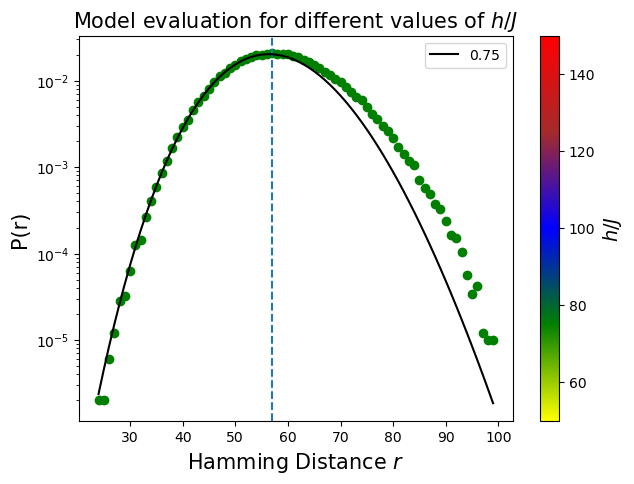

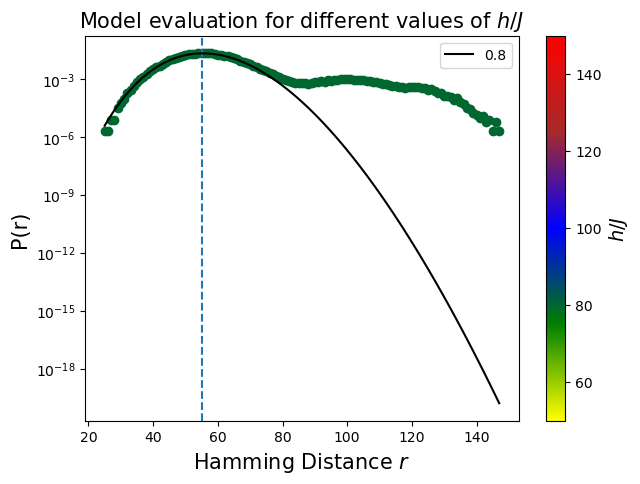

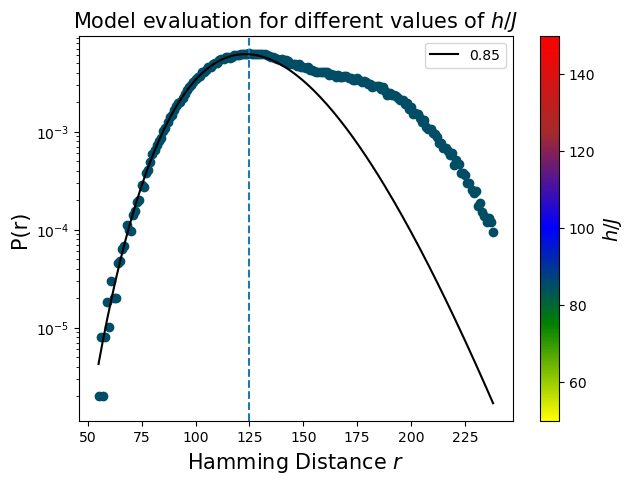

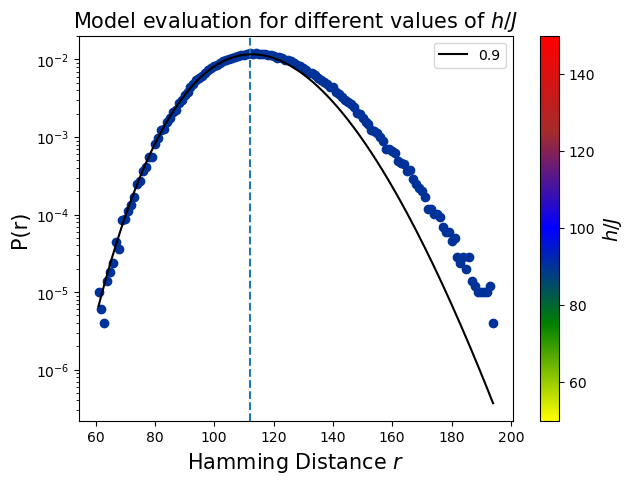

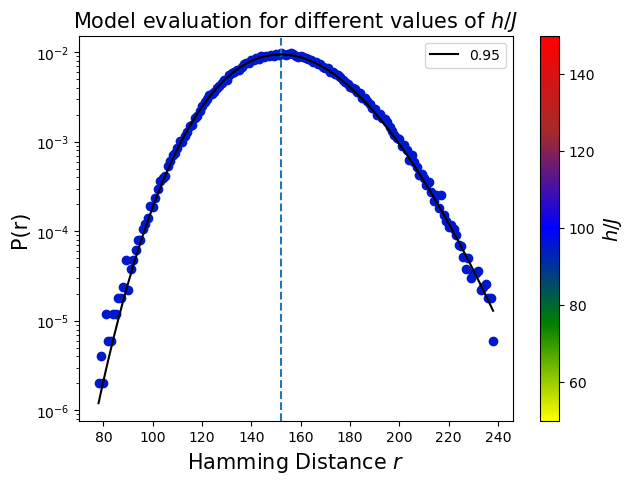

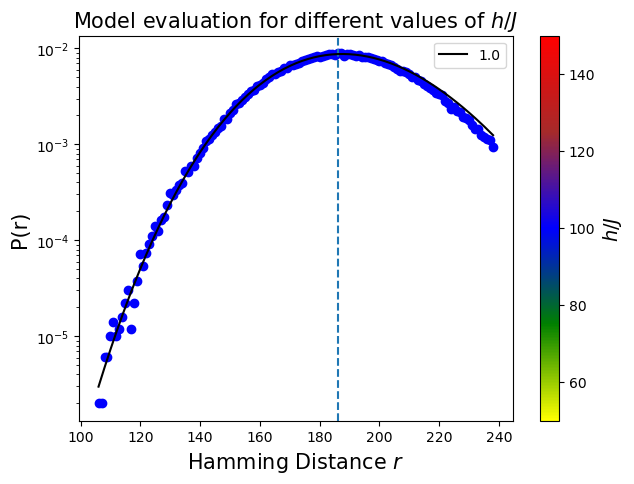

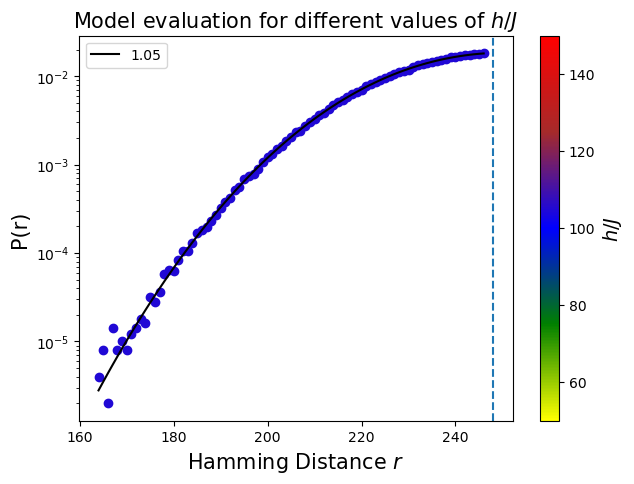

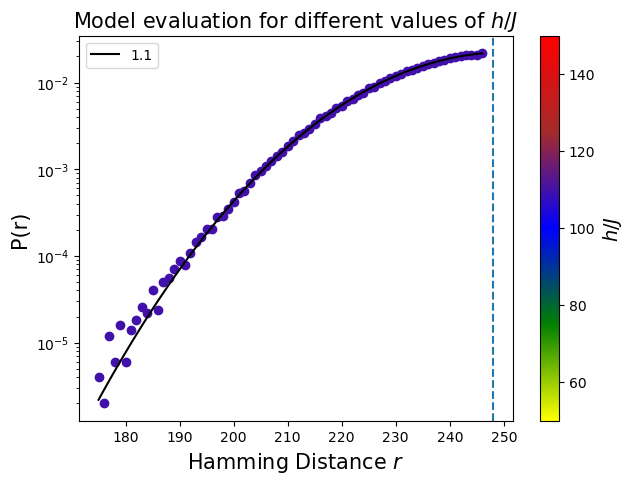

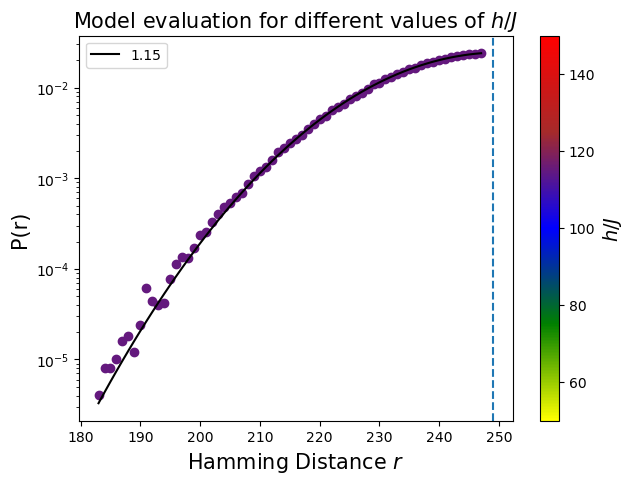

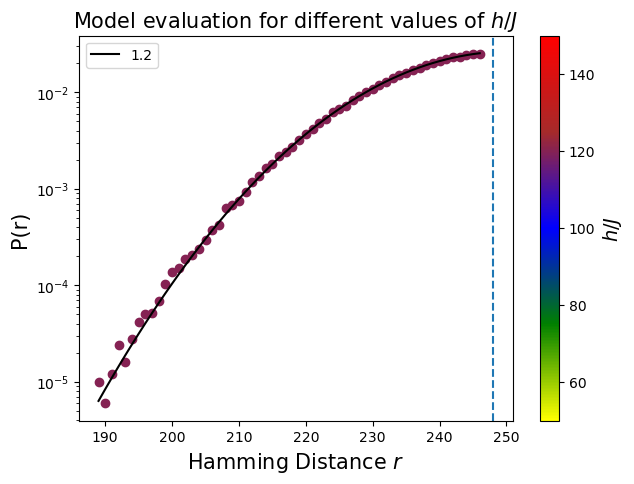

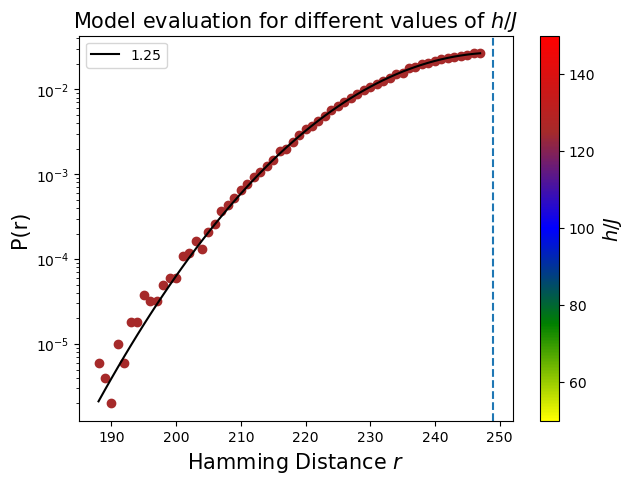

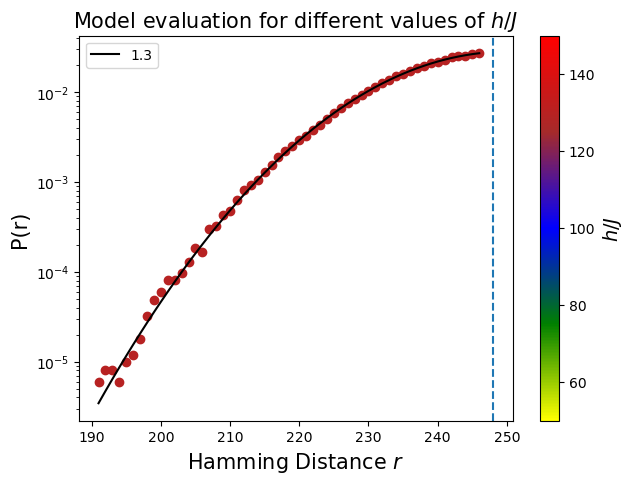

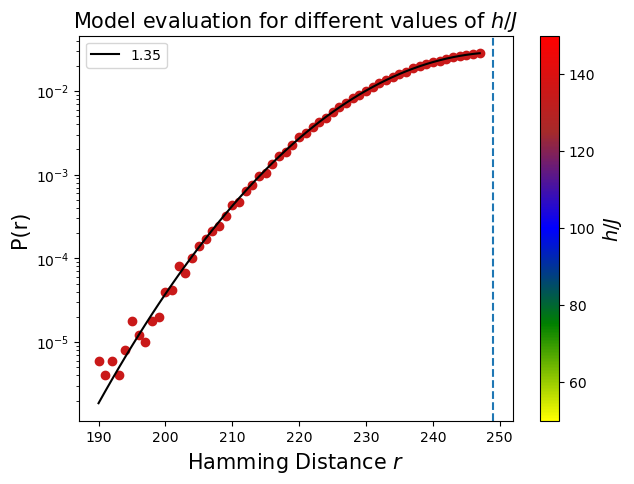

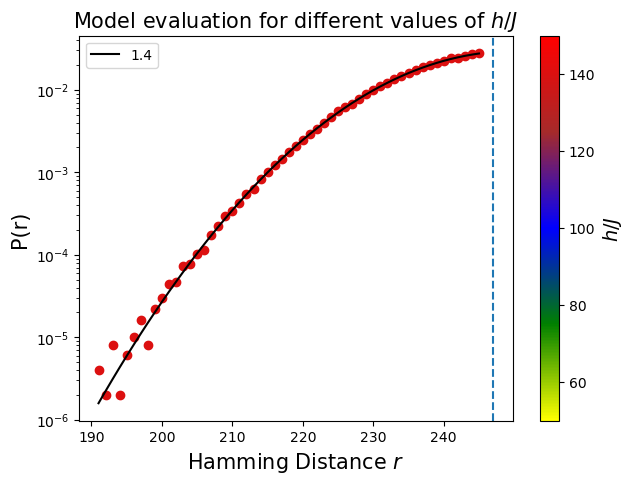

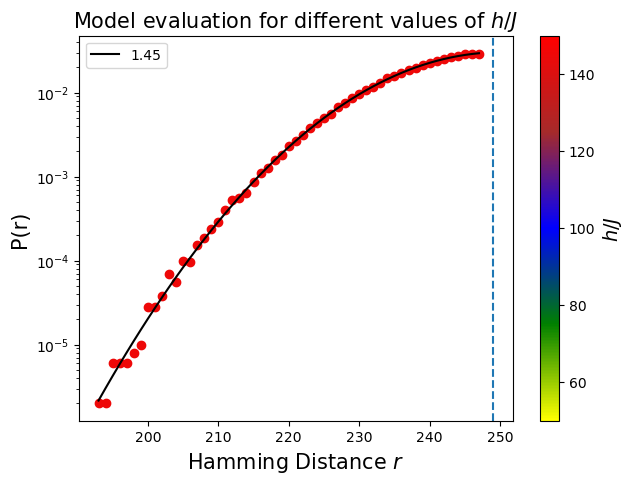

/tmp/ipykernel_20182/1982285588.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


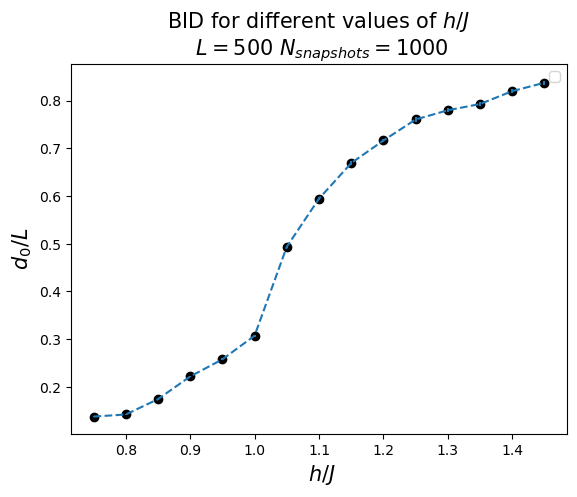

/tmp/ipykernel_20182/1982285588.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


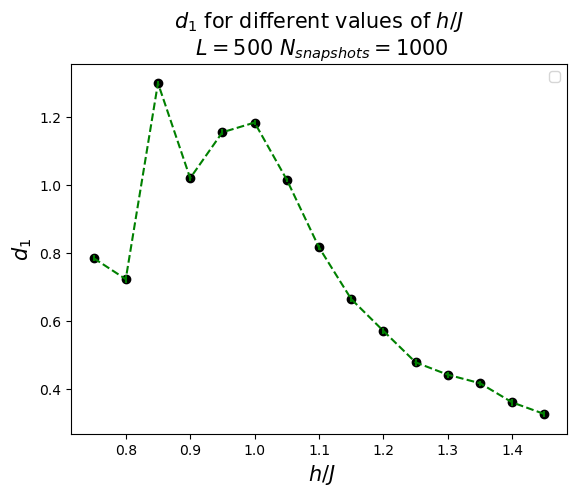

/tmp/ipykernel_20182/1982285588.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


IndexError: index 3 is out of bounds for axis 1 with size 3

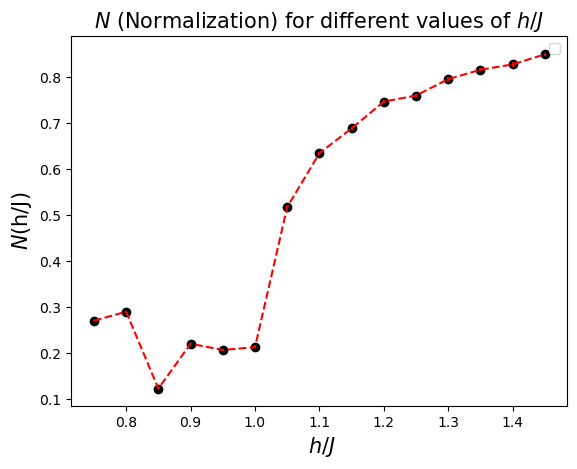

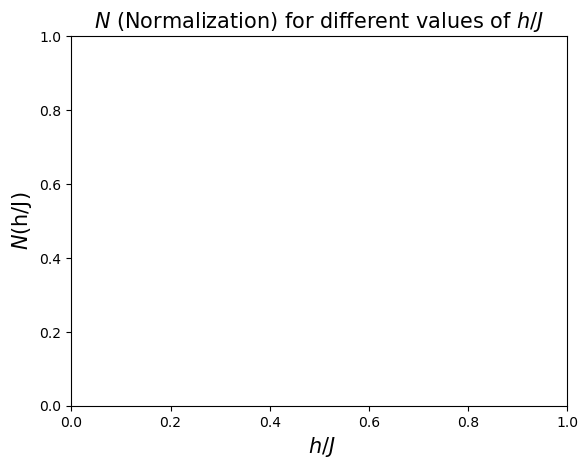

In [6]:

colors = [(0.0, 'yellow'),(0.25, "green"),(0.5, 'blue'),(0.75,"brown"),(1.0, 'red')]
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)
AA=[i for i in range(len(L))]
print(AA)
ID0=[]
DID0=[]

alp=0.5
for i in range(len(AA)):
    
    par=initial_guess(PDF[AA[i]],L[i]*W)
    
    x=np.arange(par[0],par[1],1,)
    eps=10**(-3)
    init_0=[1.0,1.0,par[1]]
    A=so.curve_fit(exp_Ansatz,x,(PDF[AA[i]][par[0]:par[1]]),p0=(init_0[0],init_0[1],init_0[2]))

    ID0.append(A[0])
    DID0.append(np.sqrt(np.diag(A[1])))

ID0=np.array(ID0)
DID0=np.array(DID0)
#fig,axis=plt.subplots(1,1,figsize=(7,5))
#plt.title("Model evaluation for different values of $h/J$",fontsize=15)
#plt.xlabel("Hamming Distance $r$",fontsize=15)
#plt.ylabel("P(r)",fontsize=15)
#plt.yscale("log")
#plt.ylim([1e-6,1e-1])
for i in range(0,len(AA)):
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    plt.title("Model evaluation for different values of $L$",fontsize=15)
    plt.xlabel("Hamming Distance $r$",fontsize=15)
    plt.ylabel("P(r)",fontsize=15)
    plt.yscale("log")
    #plt.ylim([1e-6,1e-1])
    par=initial_guess(PDF[AA[i]],L*W)
    #x=np.arange(par[0],par[2],1)/(L*W)
    x=np.arange(par[0],par[2],1)
    #print(ID0[i,:])
    #print(DID0[i,:])
    #y=log_Ansatz(x,ID0[i,0],ID0[i,1],ID0[i,2])
    #y=np.exp(y)
    y=exp_Ansatz(x,ID0[i,0],ID0[i,1],ID0[i,2])
    axis.axvline(x=par[1],linestyle="dashed")
    #print("y....")
    #print(np.exp(y))
    #axis.plot(x,y,color=cmap(norm(G[AA[i]])),label=str(np.round(0.01*G[AA[i]],2)))
    axis.plot(x,y,color="black",label=str(L[i]))
    axis.scatter(x,PDF[AA[i]][par[0]:par[2]],color=cmap(norm(G[AA[i]])))
#plt.legend(bbox_to_anchor=[1.0, 1.0])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
# Create the colorbar
    cbar = plt.colorbar(sm,ax=axis,label='$L$')
    cbar.set_label('$L$', fontsize=14)
    plt.legend()
    plt.savefig("validation"+str(i)+name_figs)
    plt.show()

xx=[1/G[a] for a in AA]
plt.figure()
plt.title("BID for different values of $L$ \n  $N_{snapshots}="+str(NS)+"$",fontsize=15)
plt.xlabel(" $1/L$",fontsize=15)
plt.ylabel("$d_0/L$",fontsize=15)
plt.errorbar(xx,ID0[:,2]/L,yerr=DID0[:,2]/L,linestyle="dashed")
plt.scatter(xx,ID0[:,2]/L,color="black")
plt.legend()
plt.savefig("BID"+name_figs)

plt.show()

plt.figure()
plt.title("$d_1$ for different values of $L$ \n $N_{snapshots}="+str(NS)+"$",fontsize=15)
plt.xlabel(" $1/L$",fontsize=15)
plt.ylabel("$d_1$",fontsize=15)
plt.errorbar(xx,ID0[:,1],yerr=DID0[:,1],color="green",linestyle="dashed")
plt.scatter(xx,ID0[:,1],color="black")
plt.legend()
plt.savefig("D1"+name_figs)

plt.show()

plt.figure()
plt.title("$N$ (Normalization) for different values of $h/J$",fontsize=15)
plt.xlabel(" $1/L$",fontsize=15)
plt.ylabel("$N$(L)",fontsize=15)
plt.errorbar(xx,ID0[:,0],yerr=DID0[:,0],color="red",linestyle="dashed")
plt.scatter(xx,ID0[:,0],color="black")
plt.legend()
plt.savefig("N"+name_figs)

plt.figure()
plt.title("$N$ (Normalization) for different values of $L$",fontsize=15)
plt.xlabel(" $1/L$",fontsize=15)
plt.ylabel("$N$(L)",fontsize=15)
plt.errorbar(xx,ID0[:,3],yerr=DID0[:,3],color="red",linestyle="dashed")
plt.scatter(xx,ID0[:,3],color="black")
plt.legend()
plt.savefig("N"+name_figs)


plt.show()

In [ ]:
x=np.arange(0,L*W,1)
fig,axis=plt.subplots(1,2,figsize=(12,5))

axis[0].set_title(r'$ \;Cumulative \; Distribution \; Function $ '+"\n"+r" $L="+str(L)+"$"+" $W="+str(W)+"$")
axis[1].set_title(r'$Probability \; Density \; Function$ '+"\n"+r" $L="+str(L)+"$ "+" $W="+str(W)+"$")
axis[0].set_xlabel("$Hamming\; distance$",fontsize=15)
axis[1].set_xlabel("$Hamming\; distance$",fontsize=15)
axis[0].set_ylabel("$\% \;N_{conf}$",fontsize=15)

for i in range(0,len(G)):
    #plt.xscale("log")
    #plt.yscale("log")
    #t=axis[0].errorbar(x,file[i]["D"]/NS,yerr=file[i]["dD"]/NS,color=cmap(norm(G[i])),label="$NL"+str(G[i])+"$")
    #axis[1].errorbar(x,PDF[i],yerr=DPDF[i],color=cmap(norm(G[i])),label="$NL"+str(G[i])+"$")
    a=cmap(norm(G[i]))
    t=axis[0].errorbar(x,file[i]["D"]/NS,color=a,label="$NL"+str(G[i])+"$")
    axis[1].errorbar(x,PDF[i],color=a,label="$NL"+str(G[i])+"$")

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
# Create the colorbar
cbar = plt.colorbar(sm, ax=axis, label='$h/J$')
cbar.set_label('$h/J$', fontsize=14)
plt.savefig(name_figs+"Hamming_distance.png")
plt.show()

In [ ]:
# GRID
# Close to the criticality
L=3500
delta=50
print(len(G))
G_crit=[i for i in range(30,len(G))]
size=len(G_crit)
D1_guess=np.linspace(1.0,3.0,100)


ID1=[[] for i in range(size)]
KL=[[] for i in range(size) ]
DID1=[[] for i in range(size)]

for i in range(len(G_crit)):
    alp_I,alp_F,D0_guess=initial_guess(PDF[G_crit[i]],delta,L*W)
    print(alp_I,alp_F,D0_guess)
    x=np.arange(alp_I,alp_F,1)/L*W
    for d1 in range(len(D1_guess)):    
        print(np.log(PDF[G_crit[i]][alp_I:alp_F]))
        A=so.curve_fit(log_Ansatz,x,np.log(PDF[G_crit[i]][alp_I:alp_F]),p0=(1.0,D1_guess[d1]*L*W,D0_guess))
        Y_emp=PDF[G_crit[i]][alp_I:alp_F]/np.sum(PDF[G_crit[i]][alp_I:alp_F])
        Y_test=log_Ansatz(x,A[0][0],A[0][1],A[0][2])
        Y_test=np.exp(Y_test)
        Y_test=Y_test/np.sum(Y_test)
        KL[i].append(logKL(Y_test,Y_emp))
        ID1[i].append(A[0][1])

In [ ]:
# Create the subplots
cmap = "viridis"

for i in range(len(G_crit)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# First subplot: Scatter plot of D1_guess vs. ID1[0]
    axs[0].set_title("Scatter Plot of $D_1$ for $G="+str(round(G[G_crit[i]]*0.01,2))+"$", fontsize=15)
    scatter = axs[0].scatter(D1_guess, np.array(ID1[i])/L, c=KL[i], cmap=cmap, norm=norm)
    axs[0].set_xlabel("Initial guess $D_1$", fontsize=15)
    axs[0].set_ylabel("Converged $D_1$", fontsize=15)
    cbar = fig.colorbar(scatter, ax=axs[0])
    cbar.set_label('$KL$', fontsize=12)

# Second subplot: Line or scatter plot of D1_guess vs. KL[0]
    axs[1].set_title("Plot of $KL$ vs $D_1$ for $G="+str(round(G[G_crit[i]]*0.01,2))+"$", fontsize=15)
    axs[1].plot(D1_guess, KL[i], 'o-', label="$KL$", color='blue', alpha=0.7)  # Use 'o-' for points connected by lines
    axs[1].set_xlabel("Initial guess $D_1$", fontsize=15)
    axs[1].set_ylabel("$KL$", fontsize=15)
    axs[1].legend(fontsize=15)

# Adjust layout
    plt.tight_layout()
    plt.savefig("D1G"+str(G_crit[i])+"_conv.png")
    plt.show()

In [9]:
ID0

[]